In [ ]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import os
import torch

import stLVG_upload
from stLVG_upload.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata, run_SLAT_AGF_contrast
from stLVG_upload.viz import match_3D_multi, hist, Sankey, build_3D
from stLVG_upload.metrics import region_statistics


In [2]:
file_path_1 = os.path.join('D:/ppppaper/data/DLPFC/DLPFC/','151674')
adata_1 = sc.read_visium(path=file_path_1, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata_1.var_names_make_unique(join="++")

Ann_df_1 = pd.read_csv(os.path.join(file_path_1 , '151674_annotation.txt'),sep ='\t', header=0 , index_col=0)
Ann_df_1.loc[Ann_df_1['Layer'].isna(),'Layer'] = "unknown"
adata_1.obs['annotation'] = Ann_df_1.loc[adata_1.obs_names, 'Layer'].astype('category')

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
file_path_2 = os.path.join('D:/ppppaper/data/DLPFC/DLPFC/','151675')
adata_2 = sc.read_visium(path=file_path_2, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata_2.var_names_make_unique(join="++")

Ann_df_2 = pd.read_csv(os.path.join(file_path_2 , '151675_annotation.txt'),sep ='\t', header=0 , index_col=0)
Ann_df_2.loc[Ann_df_2['Layer'].isna(),'Layer'] = "unknown"
adata_2.obs['annotation'] = Ann_df_2.loc[adata_2.obs_names, 'Layer'].astype('category')

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
x1_coords=adata_1.obsm['spatial'][:,0]
y1_coords=adata_1.obsm['spatial'][:,1]
x2_coords=adata_2.obsm['spatial'][:,0]
y2_coords=adata_2.obsm['spatial'][:,1]
locations_1 = np.array([x1_coords, y1_coords])
locations_2 = np.array([x2_coords, y2_coords])

locations_1_tensor = torch.tensor(locations_1)
locations_2_tensor = torch.tensor(locations_2)
locations_1_tensor = locations_1_tensor.transpose(0, 1)
locations_1_tensor = locations_1_tensor.to(dtype=torch.float32)
locations_2_tensor = locations_2_tensor.transpose(0, 1)
locations_2_tensor = locations_2_tensor.to(dtype=torch.float32)
location = [locations_1_tensor, locations_2_tensor]

In [5]:
Cal_Spatial_Net(adata_1, k_cutoff=10, model='KNN')
Cal_Spatial_Net(adata_2, k_cutoff=10, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 38433 edges, 3673 cells.
10.463653689082493 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 37544 edges, 3592 cells.
10.452115812917596 neighbors per cell on average.


In [6]:
edges, features = load_anndatas([adata_1, adata_2], feature='DPCA')

Use DPCA feature to format graph


d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [7]:
embd0_0, embd0_1, embd1_0, embd1_1, embd0, embd1, time = run_SLAT_AGF_contrast(features, edges, location)

GPU is not available
Running
---------- epochs: 1 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.02 s ----

---------- epochs: 2 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.02 s ----

---------- epochs: 3 ----------
---- Ran row_normalize in 0.03 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 4 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.02 s ----

---------- epochs: 5 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.01 s ----

---------- epochs: 6 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.01 s ----

---- Ran row_normalize in 0.03 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 1 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.03 s ----



D:\ppppaper\SLAT\SLAT-main\SLAT-main\scSLAT\model\graphconv\AGF_Com.py:109: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Copy.cpp:301.)
  complex_array_tensor = torch.tensor(complex_array, dtype=torch.float32)


---------- epochs: 2 ----------
---- Ran row_normalize in 0.07 s ----

---- Ran row_normalize in 0.01 s ----

---------- epochs: 3 ----------
---- Ran row_normalize in 0.03 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 4 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.02 s ----

---------- epochs: 5 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 6 ----------
---- Ran row_normalize in 0.04 s ----

---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.03 s ----

---- Ran row_normalize in 0.02 s ----

---------- Combined epochs: 0 ----------
Contrastive Loss 0: 5.931824207305908
Contrastive Loss 1: 5.908995151519775
Total Combined Loss: 11.840819358825684
---------- Combined epochs: 1 ----------
Contrastive Loss 0: 5.286613464355469
Contrastive Loss 1: 5.269798755645752
Total Combined Loss: 10.556411743164062
---------- Combined epochs: 2 ----------
Contrastive Loss 

In [ ]:
adata_1.obsm['stLVG'] = embd0.detach().cpu().numpy()
adata_2.obsm['stLVG'] = embd1.detach().cpu().numpy()
adata_com = sc.concat([adata_1, adata_2], label='slice_name', keys=['slice_1', 'slice_2'])

sc.pp.neighbors(adata_com, use_rep= 'stLVG')
sc.tl.umap(adata_com)

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
d:\Anaconda\envs\scSLAT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


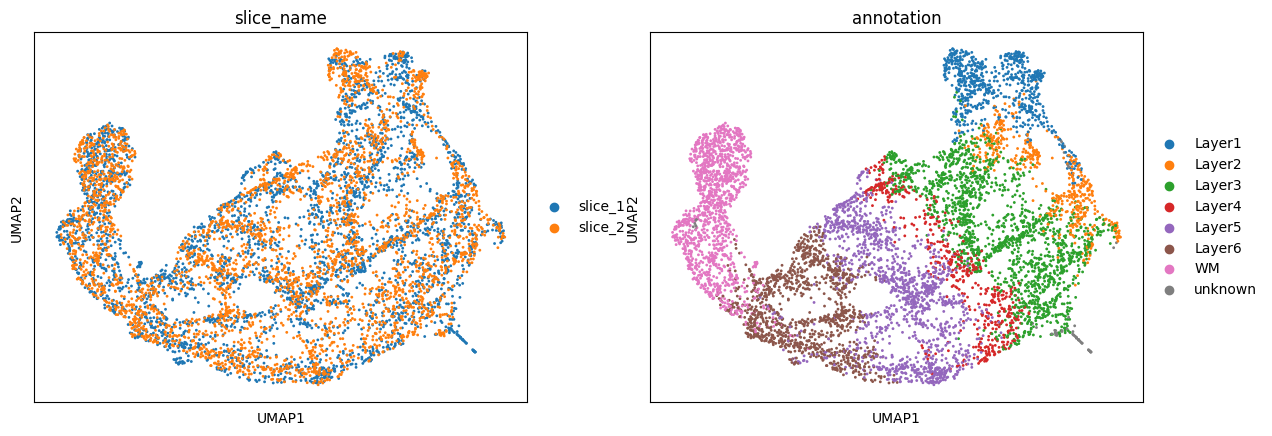

In [9]:
sc.pl.umap(adata_com, color= ['slice_name', 'annotation'])

In [10]:
spot_size = 100
pathology_color = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B",
    "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF", "#AEC7E8", "#FFBB78",
    "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94", "#F7B6D2", "#C7C7C7",
    "#DBDB8D", "#9EDAE5", "#1F9B99", "#FFCD56", "#33A02C", "#FB9A99",
    "#A6CEE3"
]

In [ ]:
lisi_scores = compute_lisi_for_adata(adata_com, obsm_key='stLVG', obs_key_list=['annotation', 'slice_name'])
print("LISI Scores:\n", lisi_scores)

LISI Scores:
 {'cLISI': 1.2777111945769721, 'iLISI': 1.7539190564978355}


In [ ]:
true_labels_1 = adata_1.obs['annotation'].to_numpy()
true_labels_2 = adata_2.obs['annotation'].to_numpy()

best, index, distance = spatial_match([embd0, embd1], adatas=[adata_1, adata_2], reorder=False)
valid_indices = best < true_labels_1.size
valid_best = best[valid_indices]
valid_indices = np.arange(len(best))[valid_indices] 

aligned_true_labels_1 = true_labels_1[valid_best]
matched_labels_3 = true_labels_2[valid_indices]

ari = adjusted_rand_score(aligned_true_labels_1, matched_labels_3)
nmi = normalized_mutual_info_score(aligned_true_labels_1, matched_labels_3)

print(f'ARI: {ari}, NMI: {nmi}')

ARI: 0.6918190563640716, NMI: 0.726065566210704


In [13]:
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['annotation']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['annotation']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

In [14]:
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()
matching_table = adata2_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

In [15]:
correct_matches = 0
total_matches = 0

for i, row in matching_table.iterrows():
    if i in matching_table.columns and row[i] > 0:
        correct_matches += row[i]
    total_matches += row.sum()


accuracy = correct_matches / total_matches if total_matches > 0 else 0
correct_matches,total_matches,accuracy

(2987, 3592, 0.8315701559020044)

In [16]:
first_indices = matching[0]
second_indices = matching[1]
second_array_labels = adata1_df.iloc[second_indices]['celltype'].values

max_index = first_indices.max()
new_labels = np.empty(max_index + 1, dtype=object)

# transfer
new_labels[first_indices] = second_array_labels

adata_2.obs['transferred_labels'] = new_labels

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

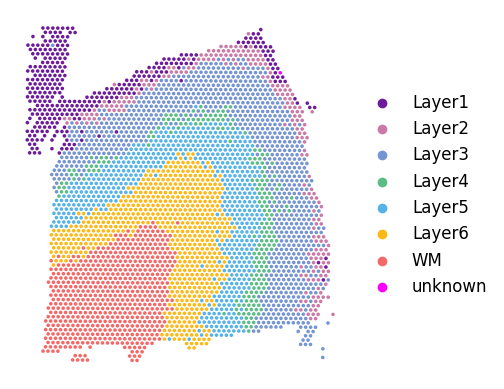

In [17]:
spot_size = 100
pathology_color = ["#6D1A9B", "#CB79A6", "#7494D2", "#59BD85", "#56B3E8", "#FDB815", "#F46867", "#FF00FF"]
sc.pl.spatial(adata_2, img_key=None, color=['transferred_labels'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [19]:
adata_1.obsm['m0'] = embd0_0.detach().cpu().numpy()
adata_2.obsm['m0'] = embd1_0.detach().cpu().numpy()

adata_com = sc.concat([adata_1, adata_2], label='slice_name', keys=['slice_1', 'slice_2'])

sc.pp.neighbors(adata_com, use_rep= 'm0')
sc.tl.umap(adata_com)

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


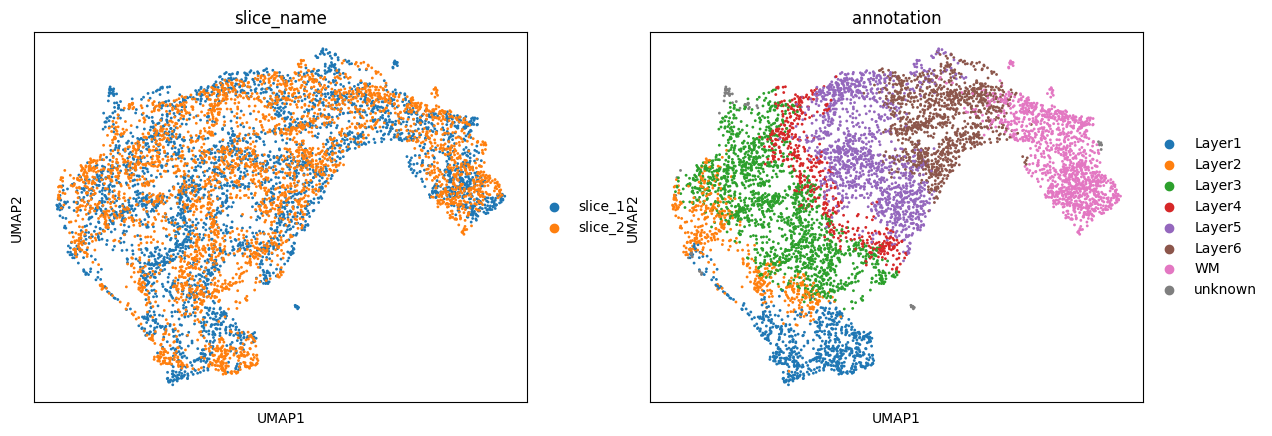

In [20]:
sc.pl.umap(adata_com, color= ['slice_name', 'annotation'])

In [21]:
lisi_scores = compute_lisi_for_adata(adata_com, obsm_key='m0', obs_key_list=['annotation', 'slice_name'])
print("LISI Scores:\n", lisi_scores)

LISI Scores:
 {'cLISI': 1.3374829597828017, 'iLISI': 1.5524108786066178}


In [ ]:
true_labels_1 = adata_1.obs['annotation'].to_numpy()
true_labels_2 = adata_2.obs['annotation'].to_numpy()

best_3, index_3, distance_3 = spatial_match([embd0_0, embd1_0], adatas=[adata_1, adata_2], reorder=False)
valid_indices = best_3 < true_labels_1.size
valid_best = best_3[valid_indices]
valid_indices = np.arange(len(best_3))[valid_indices] 

aligned_true_labels_1 = true_labels_1[valid_best]
matched_labels_3 = true_labels_2[valid_indices]

ari = adjusted_rand_score(aligned_true_labels_1, matched_labels_3)
nmi = normalized_mutual_info_score(aligned_true_labels_1, matched_labels_3)

print(f'ARI: {ari}, NMI: {nmi}')

ARI: 0.6437689116462275, NMI: 0.6851051979683326


In [23]:
adata5_df = pd.DataFrame({'index': range(embd0_0.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['annotation']})
adata6_df = pd.DataFrame({'index': range(embd1_0.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['annotation']})

matching_3 = np.array([range(index_3.shape[0]), best_3])
best_match_3 = distance_3[:,0]

In [24]:
adata6_df['target_celltype'] = adata5_df.iloc[matching_3[1,:],:]['celltype'].to_list()
matching_table_3 = adata6_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

In [25]:
correct_matches = 0
total_matches = 0

for i, row in matching_table_3.iterrows():
    if i in matching_table_3.columns and row[i] > 0:
        correct_matches += row[i]
    total_matches += row.sum()


accuracy = correct_matches / total_matches if total_matches > 0 else 0
correct_matches,total_matches,accuracy

(2876, 3592, 0.8006681514476615)

In [26]:
adata_1.obsm['m1'] = embd0_1.detach().cpu().numpy()
adata_2.obsm['m1'] = embd1_1.detach().cpu().numpy()

adata_com = sc.concat([adata_1, adata_2], label='slice_name', keys=['slice_1', 'slice_2'])

sc.pp.neighbors(adata_com, use_rep= 'm1')
sc.tl.umap(adata_com)

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


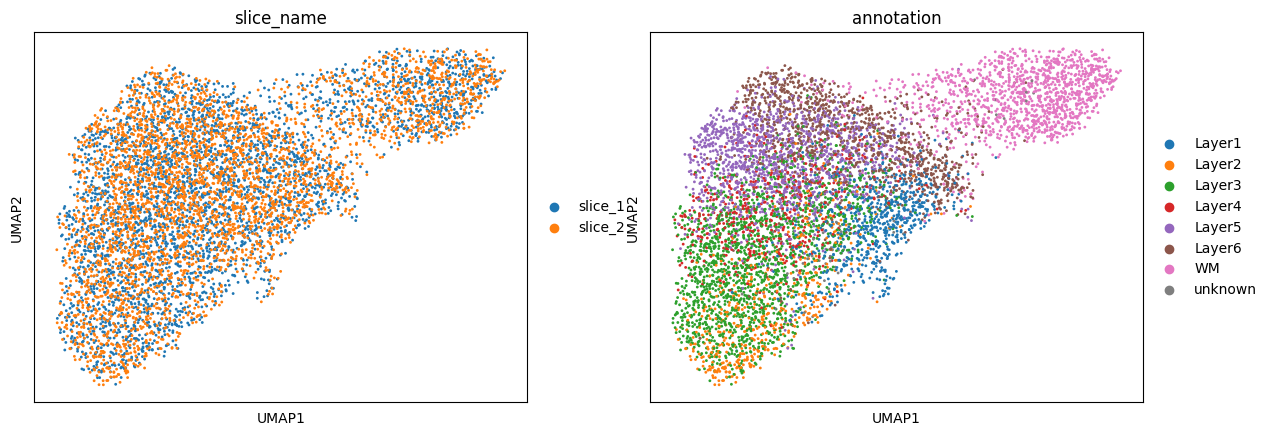

In [27]:
sc.pl.umap(adata_com, color= ['slice_name', 'annotation'])

In [ ]:
true_labels_1 = adata_1.obs['annotation'].to_numpy()
true_labels_2 = adata_2.obs['annotation'].to_numpy()

best_4, index_4, distance_4 = spatial_match([embd0_1, embd1_1], adatas=[adata_1, adata_2], reorder=False)
valid_indices = best_4 < true_labels_1.size
valid_best = best_4[valid_indices]
valid_indices = np.arange(len(best_4))[valid_indices] 

aligned_true_labels_1 = true_labels_1[valid_best]
matched_labels_3 = true_labels_2[valid_indices]

ari = adjusted_rand_score(aligned_true_labels_1, matched_labels_3)
nmi = normalized_mutual_info_score(aligned_true_labels_1, matched_labels_3)

print(f'ARI: {ari}, NMI: {nmi}')

ARI: 0.359318106180783, NMI: 0.38361236744557725


In [29]:
# adata_1.write('D:\ppppaper\data\Result\DFPLC_74.h5ad')

In [30]:
# adata_2.write('D:\ppppaper\data\Result\DFPLC_75.h5ad')

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

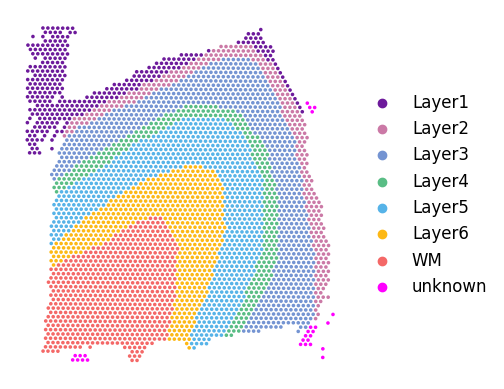

In [5]:
spot_size = 100
pathology_color = ["#6D1A9B", "#CB79A6", "#7494D2", "#59BD85", "#56B3E8", "#FDB815", "#F46867", "#FF00FF"]
sc.pl.spatial(adata_2, img_key=None, color=['annotation'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)